In [1]:
from typing import Optional, Union, Tuple, List, Callable, Dict
from tqdm.notebook import tqdm
import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler
import torch.nn.functional as nnf
import numpy as np
import shutil
from torch.optim.adam import Adam
from PIL import Image
import json
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchgeometry as tgm
import cv2
from torch.utils.data import Dataset
from torchvision import datasets
import numpy.typing as npt
from jaxtyping import Float
from torch import Tensor
from pathlib import Path
import json
import os
from torch.utils.data import DataLoader

In [2]:
import wandb
wandb.login()

wandb: Currently logged in as: jh27kim (jaihoon). Use `wandb login --relogin` to force relogin


True

In [3]:
scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
MY_TOKEN = ''
LOW_RESOURCE = False 
NUM_DDIM_STEPS = 50
GUIDANCE_SCALE = 7.5
MAX_NUM_WORDS = 77
device = torch.device('cuda:9') if torch.cuda.is_available() else torch.device('cpu')
ldm_stable = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", use_auth_token=MY_TOKEN, scheduler=scheduler)
try:
    ldm_stable.disable_xformers_memory_efficient_attention()
except AttributeError:
    print("Attribute disable_xformers_memory_efficient_attention() is missing")
tokenizer = ldm_stable.tokenizer

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
/home/jh27kim/miniconda3/envs/diffusion_inv/lib/python3.8/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:115: FutureWarning: The configuration file of this scheduler: DDIMScheduler {
  "_class_name": "DDIMScheduler",
  "_diffusers_version": "0.16.1",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "sample_max_value": 1.0,
  "set_alpha_to

In [4]:
def load_512(image_path, left=0, right=0, top=0, bottom=0):
    image = np.array(Image.open(image_path))[:, :, :3] / 255.0
    image = image.astype(np.float32)
    image = torch.tensor(image).permute(2, 0, 1).unsqueeze(0)
    
    return image

def torch_to_pil(img):
    if img.dim() == 4:
        img = img.squeeze(0)
        
    img = img.detach().cpu().permute(1, 2, 0).numpy()
    img = (img * 255.0).astype(np.uint8)
    img = Image.fromarray(img)
    
    return img

In [23]:
class DDIM_inversion:
    def __init__(self, model):
        scheduler = DDIMScheduler(beta_start=0.00085, 
                                  beta_end=0.012, 
                                  beta_schedule="scaled_linear", 
                                  clip_sample=False,
                                  set_alpha_to_one=False)

        self.model = model
        self.tokenizer = self.model.tokenizer
        self.model.scheduler.set_timesteps(NUM_DDIM_STEPS)
        self.prompt = None
        self.context = None
        self.model.vae.to(device)
        
    @property
    def scheduler(self):
        return self.model.scheduler
    
#     @torch.no_grad()
    def latent2image(self, latents, return_type='torch'):
        latents = 1 / 0.18215 * latents.detach()
        image = self.model.vae.decode(latents)['sample']
        if return_type == 'np':
            image = (image / 2 + 0.5).clamp(0, 1)
            image = image.cpu().permute(0, 2, 3, 1).numpy()[0]
            image = (image * 255).astype(np.uint8)
        
        if return_type == 'torch':
            image = (image / 2 + 0.5).clamp(0, 1)
            
        return image

    
    @torch.no_grad()
    def image2latent(self, image):
        with torch.no_grad():
            if type(image) is Image:
                image = np.array(image)
            if type(image) is torch.Tensor and image.shape[-1] == 64:
                latents = image
            else:
                image = (image - 0.5) * 2.0
                if image.dim == 3:
                    image = image.permute(2, 0, 1).unsqueeze(0).to(device)
                
                latents = self.model.vae.encode(image)['latent_dist'].mean
                latents = latents * 0.18215
        return latents

    
    @torch.no_grad()
    def init_prompt(self, prompt: str):
        uncond_input = self.model.tokenizer(
            [""], padding="max_length", max_length=self.model.tokenizer.model_max_length,
            return_tensors="pt"
        )
        uncond_embeddings = self.model.text_encoder(uncond_input.input_ids.to(self.model.device))[0]
        text_input = self.model.tokenizer(
            [prompt],
            padding="max_length",
            max_length=self.model.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        )
        text_embeddings = self.model.text_encoder(text_input.input_ids.to(self.model.device))[0]
        self.context = torch.cat([uncond_embeddings, text_embeddings])
        self.prompt = prompt
        
        return self.context
    
    
    def prev_step(self, model_output: Union[torch.FloatTensor, np.ndarray], timestep: int, sample: Union[torch.FloatTensor, np.ndarray]):
        prev_timestep = timestep - self.scheduler.config.num_train_timesteps // self.scheduler.num_inference_steps
        alpha_prod_t = self.scheduler.alphas_cumprod[timestep]
        alpha_prod_t_prev = self.scheduler.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else self.scheduler.final_alpha_cumprod
        beta_prod_t = 1 - alpha_prod_t
        pred_original_sample = (sample - beta_prod_t ** 0.5 * model_output) / alpha_prod_t ** 0.5
        pred_sample_direction = (1 - alpha_prod_t_prev) ** 0.5 * model_output
        prev_sample = alpha_prod_t_prev ** 0.5 * pred_original_sample + pred_sample_direction
        return prev_sample
    
    
    def next_step(self, model_output: Union[torch.FloatTensor, np.ndarray], timestep: int, sample: Union[torch.FloatTensor, np.ndarray]):
        timestep, next_timestep = min(timestep - self.scheduler.config.num_train_timesteps // self.scheduler.num_inference_steps, 999), timestep
        alpha_prod_t = self.scheduler.alphas_cumprod[timestep] if timestep >= 0 else self.scheduler.final_alpha_cumprod
        alpha_prod_t_next = self.scheduler.alphas_cumprod[next_timestep]
        beta_prod_t = 1 - alpha_prod_t
        next_original_sample = (sample - beta_prod_t ** 0.5 * model_output) / alpha_prod_t ** 0.5
        next_sample_direction = (1 - alpha_prod_t_next) ** 0.5 * model_output
        next_sample = alpha_prod_t_next ** 0.5 * next_original_sample + next_sample_direction
        return next_sample
    
    
    def get_noise_pred_single(self, latents, t, context):
        noise_pred = self.model.unet(latents, t, encoder_hidden_states=context)["sample"]
        return noise_pred
    
    
    @torch.no_grad()
    def reverse_step(self, latents, prompt_embeds, start_t=0, guidance_scale=7.5):
        start_index = None
        for i, t in enumerate(self.model.scheduler.timesteps):
            if int(t.item()) == int(start_t):
                start_index = i
                break
                
        assert start_index != None
        
        timesteps = self.model.scheduler.timesteps[start_index:]
        for i, t in enumerate(timesteps):
            latent_model_input = torch.cat([latents] * 2)
            latent_model_input = self.model.scheduler.scale_model_input(latent_model_input, t)

            noise_pred = self.model.unet(
                latent_model_input,
                t,
                encoder_hidden_states=prompt_embeds
            ).sample

            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            latents = self.model.scheduler.step(noise_pred, t, latents).prev_sample
        
        return latents

    
    @torch.no_grad()
    def ddim_loop(self, latent):
        uncond_embeddings, cond_embeddings = self.context.chunk(2)
        all_latent = {"0": latent}
        latent = latent.clone().detach()
        
        for i in range(NUM_DDIM_STEPS):
            t = self.model.scheduler.timesteps[len(self.model.scheduler.timesteps) - i - 1]
            noise_pred = self.get_noise_pred_single(latent, t, cond_embeddings)
            latent = self.next_step(noise_pred, t, latent)
            all_latent[str(t.item())] = latent
            
        return all_latent
    
    
    @torch.no_grad()
    def ddim_invert(self, image):
        latent = self.image2latent(image)
        ddim_latents = self.ddim_loop(latent)
        return ddim_latents
    
    
    def invert(self, image_path: str, prompt: str):
        self.init_prompt(prompt)
        image_gt = load_512(image_path)
        ddim_latents = self.ddim_invert(image_gt)
        
        return image_gt, ddim_latents
    
    
    def load_checkpoint(self, ckpt_path, load_ckpt=-1):
        state_dict = None
        
        if load_ckpt == -1:
            ckpt_dir = os.listdir(ckpt_path)
            ckpt_dir.sort(key=lambda x: x.split("_")[-1], reverse=True)
            
            if ckpt_dir:
                ckpt_path = os.path.join(ckpt_path, ckpt_dir[-1])

                print(f"Loaded {load_ckpt} epoch checkpoint")
                state_dict = torch.load(ckpt_path)
            else:
                print(f"No checkpoint found in {ckpt_path}")

        else:
            ckpt_path = os.path.join(ckpt_path, f"state_{load_ckpt}.pt")
            
            if os.path.isfile(ckpt_path):            
                print(f"Loaded {load_ckpt} epoch checkpoint")
                state_dict = torch.load(ckpt_path)
            else:
                print(f"No checkpoint found in {ckpt_path}")
            
        return state_dict
            
        
    def save_checkpoint(self, epoch, ckpt_path, optimizer=None):
        save_ckpt_path = os.path.join(ckpt_path, f"state_{epoch}.pt")
        
        torch.save(
            {
                "decoder": self.model.vae.decoder.state_dict(),
                "epoch": epoch,
                "optimizer": optimizer.state_dict(),
            },
            save_ckpt_path,
        )
        
        print(f"Saved current state {epoch} at {ckpt_path}")
    
    
    
ddim_inversion = DDIM_inversion(ldm_stable)

### Shifting latent

In [6]:
# https://medium.com/analytics-vidhya/image-shifting-using-numpy-from-scratch-8bd52663da52

def pad_vector(vector, how, depth, constant_value=0):
    vect_shape = vector.shape[:2]
    height, width = vector.shape
        
    if (how == 'upper') or (how == 'top'):
        pp = torch.randn(depth, vect_shape[1]).to(vector)
        pv = torch.cat((pp, vector), 0)
        pv = pv[:height, :]
        
    elif (how == 'lower') or (how == 'bottom'):
        pp = torch.randn(depth, vect_shape[1]).to(vector)
        pv = torch.cat((vector, pp), 0)
        pv = pv[-height:, :]
        
    elif (how == 'left'):
        pp = torch.randn(vect_shape[0], depth).to(vector)
        pv = torch.cat((pp, vector), 1)
        pv = pv[:, :width]
        
    elif (how == 'right'):
        pp = torch.randn(vect_shape[0], depth).to(vector)
        pv = torch.cat((vector, pp), 1)
        pv = pv[:depth, -width:]
        
    else:
        return vector
    
    return pv

def shifter(vect, y, y_):
    if (y > 0):
        image_trans = pad_vector(vector=vect, how='lower', depth=y_)
    elif (y < 0):
        image_trans = pad_vector(vector=vect, how='upper', depth=y_)
    else:
        image_trans = vect
    return image_trans


def shift_image(latent_src_channel, at):
    x, y = at
    x_, y_ = abs(x), abs(y)

    if (x > 0):
        left_pad = pad_vector(vector=latent_src_channel, how='left', depth=x_)
        latent_trans = shifter(vect=left_pad, y=y, y_=y_)
    elif (x < 0):
        right_pad = pad_vector(vector=latent_src_channel, how='right', depth=x_)
        latent_trans = shifter(vect=right_pad, y=y, y_=y_)
    else:
        latent_trans = shifter(vect=latent_src_channel, y=y, y_=y_)

    return latent_trans

def translate_this(latent_src, at, with_plot=False, gray_scale=False):
    if len(at) != 2: return False
    assert latent_src.shape == (1, 4, 64, 64)
    
    shifted_latent = []
    for single_channel_latent in latent_src[0, ...]:
        shifted_channel = shift_image(
            latent_src_channel=single_channel_latent, 
            at=at)
        
        shifted_channel = shifted_channel[:64, :64]
        shifted_latent.append(shifted_channel)
        
    shifted_latent = torch.stack(shifted_latent, 0).unsqueeze(0)
    
    return shifted_latent

In [9]:
# Shifting latent
# First, convert image to latent 

cat_img_path = "./dataset/afhq/train/cat/flickr_cat_000045.jpg"
prompt = "cat"

text_embeddings = ddim_inversion.init_prompt(prompt)

# Encode real image to latent
real_image_gt = load_512(cat_img_path)
real_latent_gt = ddim_inversion.image2latent(real_image_gt.to(device))

# Decoding latent
decoded_latent_img = ddim_inversion.latent2image(real_latent_gt)

Text(0.5, 1.0, 'Translated image')

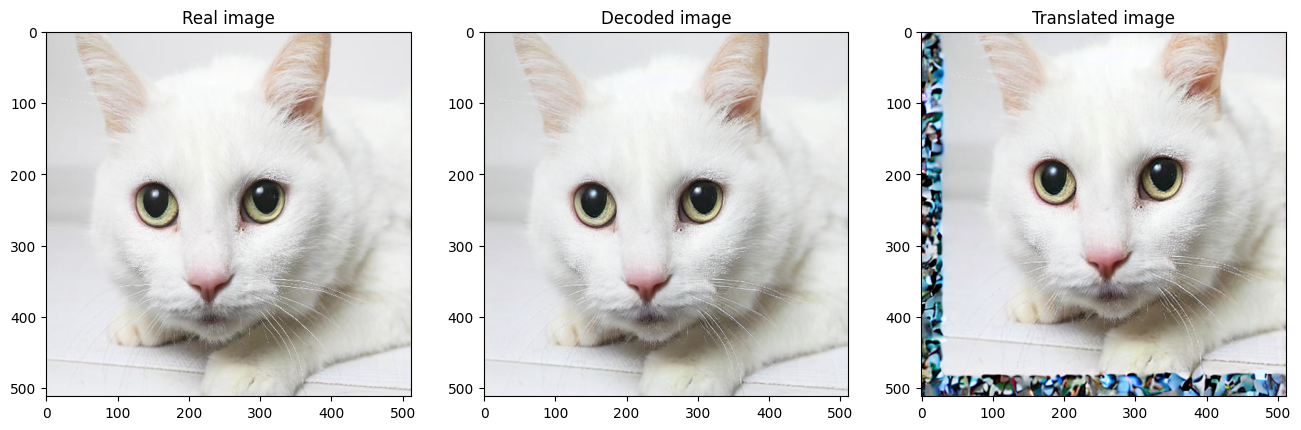

In [10]:
# Shifted latent
translated_latent = translate_this(
                        latent_src=real_latent_gt,
                        at=(4, 4))

decoded_translated_image = torch_to_pil(ddim_inversion.latent2image(translated_latent))

fig, axs = plt.subplots(1, 3, figsize=(16,9))
axs[0].imshow(torch_to_pil(real_image_gt))
axs[0].set_title("Real image")

axs[1].imshow(torch_to_pil(decoded_latent_img))
axs[1].set_title("Decoded image")

axs[2].imshow(decoded_translated_image)
axs[2].set_title("Translated image")

### Rotate latent (SO2)

In [7]:
from torchgeometry.core.conversions import deg2rad
from torchgeometry.core.homography_warper import homography_warp

# Code from
# https://kornia.readthedocs.io/en/v0.1.2/_modules/torchgeometry/core/imgwarp.html

def get_rotation_matrix2d(center, angle, scale):
    r"""Calculates an affine matrix of 2D rotation.

    The function calculates the following matrix:

    .. math::
        \begin{bmatrix}
            \alpha & \beta & (1 - \alpha) \cdot \text{x}
            - \beta \cdot \text{y} \\
            -\beta & \alpha & \beta \cdot \text{x}
            + (1 - \alpha) \cdot \text{y}
        \end{bmatrix}

    where

    .. math::
        \alpha = \text{scale} \cdot cos(\text{angle}) \\
        \beta = \text{scale} \cdot sin(\text{angle})

    The transformation maps the rotation center to itself
    If this is not the target, adjust the shift.

    Args:
        center (Tensor): center of the rotation in the source image.
        angle (Tensor): rotation angle in degrees. Positive values mean
            counter-clockwise rotation (the coordinate origin is assumed to
            be the top-left corner).
        scale (Tensor): isotropic scale factor.

    Returns:
        Tensor: the affine matrix of 2D rotation.

    Shape:
        - Input: :math:`(B, 2)`, :math:`(B)` and :math:`(B)`
        - Output: :math:`(B, 2, 3)`

    Example:
        >>> center = torch.zeros(1, 2)
        >>> scale = torch.ones(1)
        >>> angle = 45. * torch.ones(1)
        >>> M = tgm.get_rotation_matrix2d(center, angle, scale)
        tensor([[[ 0.7071,  0.7071,  0.0000],
                 [-0.7071,  0.7071,  0.0000]]])
    """
    if not torch.is_tensor(center):
        raise TypeError("Input center type is not a torch.Tensor. Got {}"
                        .format(type(center)))
    if not torch.is_tensor(angle):
        raise TypeError("Input angle type is not a torch.Tensor. Got {}"
                        .format(type(angle)))
    if not torch.is_tensor(scale):
        raise TypeError("Input scale type is not a torch.Tensor. Got {}"
                        .format(type(scale)))
    if not (len(center.shape) == 2 and center.shape[1] == 2):
        raise ValueError("Input center must be a Bx2 tensor. Got {}"
                         .format(center.shape))
    if not len(angle.shape) == 1:
        raise ValueError("Input angle must be a B tensor. Got {}"
                         .format(angle.shape))
    if not len(scale.shape) == 1:
        raise ValueError("Input scale must be a B tensor. Got {}"
                         .format(scale.shape))
    if not (center.shape[0] == angle.shape[0] == scale.shape[0]):
        raise ValueError("Inputs must have same batch size dimension. Got {}"
                         .format(center.shape, angle.shape, scale.shape))
    # convert angle and apply scale
    angle_rad = deg2rad(angle)
    alpha = torch.cos(angle_rad) * scale
    beta = torch.sin(angle_rad) * scale

    # unpack the center to x, y coordinates
    x, y = center[..., 0], center[..., 1]

    # create output tensor
    batch_size, _ = center.shape
    M = torch.zeros(batch_size, 2, 3, device=center.device, dtype=center.dtype)
    M[..., 0, 0] = alpha
    M[..., 0, 1] = beta
    M[..., 0, 2] = (1. - alpha) * x - beta * y
    M[..., 1, 0] = -beta
    M[..., 1, 1] = alpha
    M[..., 1, 2] = beta * x + (1. - alpha) * y
    return M


def warp_affine(src: torch.Tensor,
                M: torch.Tensor,
                dsize: Tuple[int, int],
                interpolation_mode: Optional[str] = 'bilinear',
                padding_mode: Optional[str] = 'zeros') -> torch.Tensor:
    r"""Applies an affine transformation to a tensor.

    The function warp_affine transforms the source tensor using
    the specified matrix:

    .. math::
        \text{dst}(x, y) = \text{src} \left( M_{11} x + M_{12} y + M_{13} ,
        M_{21} x + M_{22} y + M_{23} \right )

    Args:
        src (torch.Tensor): input tensor of shape :math:`(B, C, H, W)`.
        M (torch.Tensor): affine transformation of shape :math:`(B, 2, 3)`.
        dsize (Tuple[int, int]): size of the output image (height, width).
        mode (Optional[str]): interpolation mode to calculate output values
          'bilinear' | 'nearest'. Default: 'bilinear'.
        padding_mode (Optional[str]): padding mode for outside grid values
          'zeros' | 'border' | 'reflection'. Default: 'zeros'.

    Returns:
        torch.Tensor: the warped tensor.

    Shape:
        - Output: :math:`(B, C, H, W)`

    .. note::
       See a working example `here <https://github.com/arraiyopensource/
       torchgeometry/blob/master/docs/source/warp_affine.ipynb>`__.
    """
    if not torch.is_tensor(src):
        raise TypeError("Input src type is not a torch.Tensor. Got {}"
                        .format(type(src)))
    if not torch.is_tensor(M):
        raise TypeError("Input M type is not a torch.Tensor. Got {}"
                        .format(type(M)))
    if not len(src.shape) == 4:
        raise ValueError("Input src must be a BxCxHxW tensor. Got {}"
                         .format(src.shape))
    if not (len(M.shape) == 3 or M.shape[-2:] == (2, 3)):
        raise ValueError("Input M must be a Bx2x3 tensor. Got {}"
                         .format(src.shape))
        
    # we generate a 3x3 transformation matrix from 2x3 affine
    M_3x3: torch.Tensor = F.pad(M, (0, 0, 0, 1, 0, 0), mode="constant", value=0)
        
    M_3x3[:, 2, 2] += 1.0
    

    # launches the warper
    return transform_warp_impl(src, M_3x3, (src.shape[-2:]), dsize, interpolation_mode, padding_mode)

def transform_warp_impl(src, dst_pix_trans_src_pix, dsize_src, dsize_dst, interpolation_mode, padding_mode):
    """Compute the transform in normalized cooridnates and perform the warping.
    """
    dst_norm_trans_dst_norm = dst_norm_to_dst_norm(dst_pix_trans_src_pix, dsize_src, dsize_dst)
    
    return homography_warp(patch_src=src, 
                           dst_homo_src=torch.inverse(dst_norm_trans_dst_norm), 
                           dsize=dsize_dst, 
                           mode=interpolation_mode, 
                           padding_mode=padding_mode)

def dst_norm_to_dst_norm(dst_pix_trans_src_pix, dsize_src, dsize_dst):
    # source and destination sizes
    src_h, src_w = dsize_src
    dst_h, dst_w = dsize_dst
    
    # the devices and types
    device = dst_pix_trans_src_pix.device
    dtype = dst_pix_trans_src_pix.dtype
    
    # compute the transformation pixel/norm for src/dst
    src_norm_trans_src_pix = normal_transform_pixel(src_h, src_w).to(device).to(dtype)
    src_pix_trans_src_norm = torch.inverse(src_norm_trans_src_pix)
    dst_norm_trans_dst_pix = normal_transform_pixel(dst_h, dst_w).to(device).to(dtype)

    # compute chain transformations
    dst_norm_trans_src_norm = torch.matmul(
            dst_norm_trans_dst_pix, torch.matmul(
            dst_pix_trans_src_pix, src_pix_trans_src_norm))
    
    return dst_norm_trans_src_norm

def normal_transform_pixel(height, width):

    tr_mat = torch.Tensor([[1.0, 0.0, -1.0],
                           [0.0, 1.0, -1.0],
                           [0.0, 0.0, 1.0]])  # 1x3x3

    tr_mat[0, 0] = tr_mat[0, 0] * 2.0 / (width - 1.0)
    tr_mat[1, 1] = tr_mat[1, 1] * 2.0 / (height - 1.0)

    tr_mat = tr_mat.unsqueeze(0)

    return tr_mat

/home/jh27kim/miniconda3/envs/diffusion_inv/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/jh27kim/miniconda3/envs/diffusion_inv/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Text(0.5, 1.0, 'Rotation - reflection')

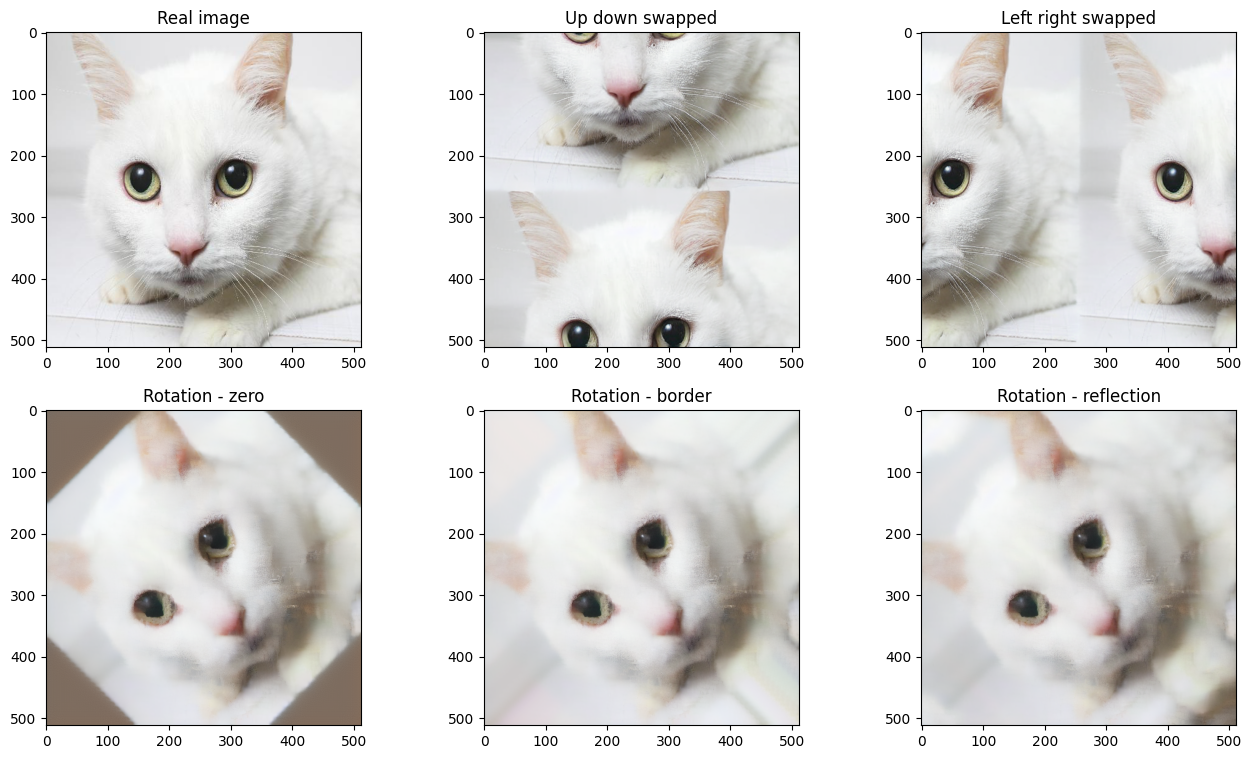

In [12]:
# Rotating latent
img = real_latent_gt

# create transformation (rotation)
alpha = 45.0  # in degrees
angle = torch.ones(1) * alpha

# define the rotation center
center = torch.ones(1, 2)
center[..., 0] = img.shape[3] / 2  # x
center[..., 1] = img.shape[2] / 2  # y

# define the scale factor
scale = torch.ones(1)

# compute the transformation matrix
# M = tgm.get_rotation_matrix2d(center.to(img), angle.to(img), scale.to(img))
M = get_rotation_matrix2d(center.to(img), angle.to(img), scale.to(img))

# apply the transformation to original image
_, _, h, w = img.shape

# latent_warped = tgm.warp_affine(img, M, dsize=(h, w))

# NOTE  # Padding mode seems to be quite important
latent_warped_zero = warp_affine(img, 
                            M, 
                            dsize=(h, w), 
                            interpolation_mode="bilinear", 
                            padding_mode="zeros")
img_warped_zero = ddim_inversion.latent2image(latent_warped_zero)
img_warped_zero = torch_to_pil(img_warped_zero)

latent_warped_border = warp_affine(img, 
                            M, 
                            dsize=(h, w), 
                            interpolation_mode="bilinear", 
                            padding_mode="border")
img_warped_border = ddim_inversion.latent2image(latent_warped_border)
img_warped_border = torch_to_pil(img_warped_border)

latent_warped_reflection = warp_affine(img, 
                            M, 
                            dsize=(h, w), 
                            interpolation_mode="bilinear", 
                            padding_mode="reflection")
img_warped_reflection = ddim_inversion.latent2image(latent_warped_reflection)
img_warped_reflection = torch_to_pil(img_warped_reflection)

##################################################

# Swapped upper half and lower half
up_down_latent_swapped = torch.zeros_like(img)
up_down_latent_swapped[:, :, :32, :] = real_latent_gt[:, :, 32:, :]
up_down_latent_swapped[:, :, 32:, :] = real_latent_gt[:, :, :32, :]
up_down_img_swapped = ddim_inversion.latent2image(up_down_latent_swapped)
up_down_img_swapped = torch_to_pil(up_down_img_swapped)

# Swapped left half and right half
left_right_latent_swapped = torch.zeros_like(img)
left_right_latent_swapped[:, :, :, 32:] = real_latent_gt[:, :, :, :32]
left_right_latent_swapped[:, :, :, :32] = real_latent_gt[:, :, :, 32:]
left_right_img_swapped = ddim_inversion.latent2image(left_right_latent_swapped)
left_right_img_swapped = torch_to_pil(left_right_img_swapped)

fig, axs = plt.subplots(2, 3, figsize=(16,9))
axs[0][0].imshow(torch_to_pil(real_image_gt))
axs[0][0].set_title("Real image")

axs[0][1].imshow(up_down_img_swapped)
axs[0][1].set_title("Up down swapped")

axs[0][2].imshow(left_right_img_swapped)
axs[0][2].set_title("Left right swapped")

axs[1][0].imshow(img_warped_zero)
axs[1][0].set_title("Rotation - zero")

axs[1][1].imshow(img_warped_border)
axs[1][1].set_title("Rotation - border")

axs[1][2].imshow(img_warped_reflection)
axs[1][2].set_title("Rotation - reflection")

In [19]:
del decoded_latent_img
torch.cuda.empty_cache()

### Fine tune decoder

### 1. Fine tune decoder directly

In [8]:
for name, param in ddim_inversion.model.vae.decoder.named_parameters():
    param.requires_grad_(True)

optimizer = torch.optim.Adam(ddim_inversion.model.vae.decoder.parameters(), lr=0.0001)
L2_loss = torch.nn.MSELoss()

In [10]:
class CustomImageDataset(Dataset):
    def __init__(self, metadata, transform=None, target_transform=None):
        self.metadata = metadata        
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.metadata)

    def get_numpy_image(self, image_idx: int) -> npt.NDArray[np.uint8]:
        """Returns the image of shape (H, W, 3 or 4).

        Args:
            image_idx: The image index in the dataset.
        """
        
        image_filepath = self.metadata[str(image_idx)]["filepath"]
        pil_image = Image.open(image_filepath).resize((512, 512))
        
#         if self.scale_factor != 1.0:
#             width, height = pil_image.size
#             newsize = (int(width * self.scale_factor), int(height * self.scale_factor))
#             pil_image = pil_image.resize(newsize, resample=Image.BILINEAR)
            
        image = np.array(pil_image, dtype="uint8")  # shape is (h, w) or (h, w, 3 or 4)
        if len(image.shape) == 2:
            image = image[:, :, None].repeat(3, axis=2)
            
        assert image.shape[0] == image.shape[1] == 512
        
        assert len(image.shape) == 3
        assert image.dtype == np.uint8
        assert image.shape[2] in [3, 4], f"Image shape of {image.shape} is in correct."
        
        return image

    def get_image(self, image_idx: int) -> Float[Tensor, "image_height image_width num_channels"]:
        """Returns a 3 channel image.

        Args:
            image_idx: The image index in the dataset.
        """
        
        image = torch.from_numpy(self.get_numpy_image(image_idx).astype("float32") / 255.0)
        image = image.permute(2, 0, 1)
        
        assert image.shape[0] == 3
        return image

    def get_data(self, image_idx: int) -> Dict:
        """Returns the ImageDataset data as a dictionary.

        Args:
            image_idx: The image index in the dataset.
        """
        
        image = self.get_image(image_idx)
        data = {"image_idx": image_idx, "image": image}
#         data.update(metadata)
        
        return data

    def __getitem__(self, image_idx: int) -> Dict:
        data = self.get_data(image_idx)
        return data

    @property
    def image_filenames(self) -> List[Path]:
        """
        Returns image filenames for this dataset.
        The order of filenames is the same as in the Cameras object for easy mapping.
        """

        return self.image_filenames

In [24]:
TRAIN_DATADIR = "./dataset/afhq/train/cat"
TEST_DATADIR = "./dataset/afhq/val/cat"

TRAIN_BATCH_SIZE = 2
TEST_BATCH_SIZE = 2

TOTAL_TRAIN_DATASET = len(cat_train_dataset)
TOTAL_TEST_DATASET = len(cat_valid_dataset)

train_metadata = dict()
with open(os.path.join(TRAIN_DATADIR, "metadata.json"), "r") as f1:
    train_metadata = json.load(f1)
    

valid_metadata = dict()
with open(os.path.join(TEST_DATADIR, "metadata.json"), "r") as f2:
    valid_metadata = json.load(f2)
    
cat_train_dataset = CustomImageDataset(train_metadata)
cat_valid_dataset = CustomImageDataset(valid_metadata)

train_dataloader = DataLoader(cat_train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(cat_valid_dataset, batch_size=TEST_BATCH_SIZE, shuffle=True)

In [27]:
MAX_EPOCH = 10
VAL_EPOCH = 1
START_EPOCH = 0

ckpt_path = "./ckpt"

state_dict = ddim_inversion.load_checkpoint(ckpt_path, load_ckpt=-1)
if state_dict != None:
    ddim_inversion.model.vae.decoder.load_state_dict(state_dict["decoder"])
    optimizer.load_state_dict(state_dict["optimizer"])
    START_EPOCH = state_dict["epoch"]

No checkpoint found in ./ckpt


In [28]:
wandb.init(project="afhq-SO2-test",
           config={
               "batch_size": TRAIN_BATCH_SIZE,
           })

train/train loss,▁█▃▃▂▂▃▂▃▂▂▆▁▂▁▁▄▂▂▅▁▃▆▂
train/train loss,0.00166


In [38]:
# For interactive GUI

# %wandb

In [29]:
SCALE = 1.0
total_loss = 1e9
VISUALIZE_TRAINING = 50

for ep in range(START_EPOCH, MAX_EPOCH):
    train_loss = 0.0
    val_loss = 0.0
    
    for i, train_data in enumerate(train_dataloader):       
        image_idx = train_data["image_idx"]
        src_img = train_data["image"].to(device)
        src_latent = ddim_inversion.image2latent(src_img)

        batch_size = src_latent.shape[0]

        angle = (torch.rand(batch_size) - 0.5) * 2 # -1 ~ 1
        angle *= 30.0
        scale = torch.ones(batch_size) * SCALE
        
        # Latent warp
        latent_center = torch.ones(batch_size, 2)
        latent_center[..., 0] = src_latent.shape[3] / 2  # x
        latent_center[..., 1] = src_latent.shape[2] / 2  # y

        _, _, latent_h, latent_w = src_latent.shape
        latent_SO2 = get_rotation_matrix2d(latent_center.to(src_img), angle.to(src_img), scale.to(src_img))
        SO2_warp_latent = warp_affine(src_latent, 
                                latent_SO2, 
                                dsize=(latent_h, latent_w), 
                                interpolation_mode="bilinear", 
                                padding_mode="reflection")
        SO2_warp_img = ddim_inversion.latent2image(SO2_warp_latent, return_type="torch")
        
        # Image warp
        img_center = torch.ones(batch_size, 2)
        img_center[..., 0] = src_img.shape[3] / 2  # x
        img_center[..., 1] = src_img.shape[2] / 2  # y
        img_SO2 = get_rotation_matrix2d(img_center.to(src_img), angle.to(src_img), scale.to(src_img)) 
        _, _, img_h, img_w = src_img.shape
        
        tar_img = warp_affine(src_img, 
                              img_SO2, 
                              dsize=(img_h, img_w), 
                              interpolation_mode="bilinear", 
                              padding_mode="reflection")
                
        optimizer.zero_grad()
        loss = L2_loss(SO2_warp_img, tar_img)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        training_log = {
            'train/train loss': loss.item()
        }
        
        if ((i + 1) % VISUALIZE_TRAINING == 0):
            training_log["train/source_img"] = wandb.Image(torch_to_pil(src_img[0, ...]))
            training_log["train/target_img"] = wandb.Image(torch_to_pil(tar_img[0, ...]))
            training_log["train/warped_img"] = wandb.Image(torch_to_pil(SO2_warp_img[0, ...]))

        wandb.log(
            training_log, step=i+1
        )
                
    train_loss /= TOTAL_TRAIN_DATASET
    print(f"Epoch: {ep} Train loss: {train_loss}")
    
    if ep % VAL_EPOCH == 0:
        with torch.no_grad():
            for j, val_data in enumerate(test_dataloader):
                image_idx = val_data["image_idx"]
                src_img = val_data["image"].to(device)
                src_latent = ddim_inversion.image2latent(src_img)

                batch_size = src_latent.shape[0]

                angle = (torch.rand(batch_size) - 0.5) * 2 # -1 ~ 1
                angle *= 30.0
                scale = torch.ones(batch_size) * SCALE

                # Latent warp
                latent_center = torch.ones(batch_size, 2)
                latent_center[..., 0] = src_latent.shape[3] / 2  # x
                latent_center[..., 1] = src_latent.shape[2] / 2  # y

                _, _, latent_h, latent_w = src_latent.shape
                latent_SO2 = get_rotation_matrix2d(latent_center.to(src_img), angle.to(src_img), scale.to(src_img))
                SO2_warp_latent = warp_affine(src_latent, 
                                        latent_SO2, 
                                        dsize=(latent_h, latent_w), 
                                        interpolation_mode="bilinear", 
                                        padding_mode="reflection")
                SO2_warp_img = ddim_inversion.latent2image(SO2_warp_latent, return_type="torch")

                # Image warp
                img_center = torch.ones(batch_size, 2)
                img_center[..., 0] = src_img.shape[3] / 2  # x
                img_center[..., 1] = src_img.shape[2] / 2  # y
                img_SO2 = get_rotation_matrix2d(img_center.to(src_img), angle.to(src_img), scale.to(src_img)) 
                _, _, img_h, img_w = src_img.shape

                tar_img = warp_affine(src_img, 
                                      img_SO2, 
                                      dsize=(img_h, img_w), 
                                      interpolation_mode="bilinear", 
                                      padding_mode="reflection")

                loss = L2_loss(SO2_warp_img, tar_img)
                val_loss += loss.item()
                
                wandb.log({'test/test loss': loss.item()}, step=j+1)
            
        val_loss /= TOTAL_TEST_DATASET
        print(f"Epoch: {ep} Validation loss: {val_loss} Total loss: {total_loss}")

    if ep == MAX_EPOCH - 1 or val_loss < total_loss:
        total_loss = val_loss
        ddim_inversion.save_checkpoint(epoch=ep, ckpt_path=ckpt_path, optimizer=optimizer)


Epoch: 0 Train loss: 6.201978915807558
Epoch: 0 Validation loss: 0.28849987950525247 Total loss: 1000000000.0
Saved current state 0 at ./ckpt
Epoch: 1 Train loss: 5.788705788407242
Epoch: 1 Validation loss: 0.2785382565925829 Total loss: 0.28849987950525247
Saved current state 1 at ./ckpt


KeyboardInterrupt: 

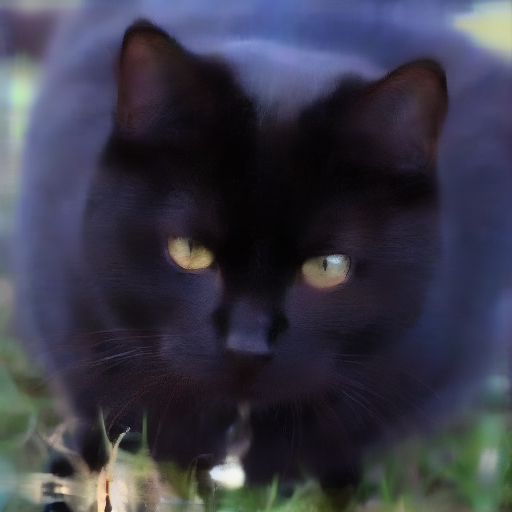

In [83]:
torch_to_pil(SO2_warp_img[1, ...])

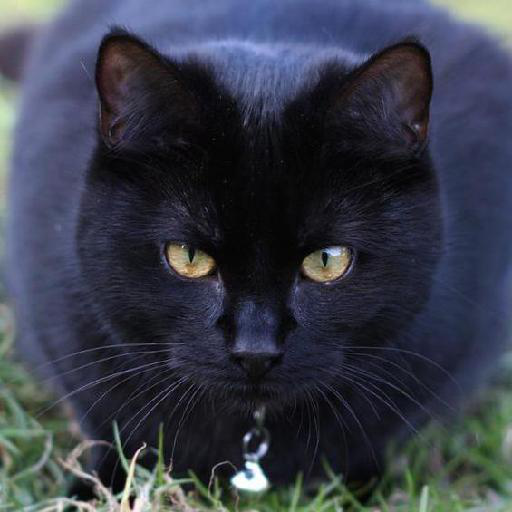

In [84]:
torch_to_pil(src_img[1, ...])

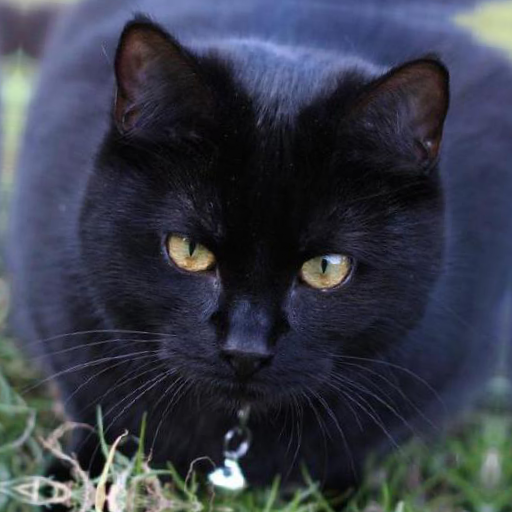

In [85]:
torch_to_pil(tar_img[1, ...])

In [31]:
!pip install wandb -qU